# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Описание проекта**  
Заказчик этого исследования — сеть отелей «Как в гостях».  

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.  

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Бизнес-метрика и другие данные**  
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.  

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.  

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.  

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

**Описание данных**  
В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:  
`id` — номер записи;  
`adults` — количество взрослых постояльцев;  
`arrival_date_year` — год заезда;  
`arrival_date_month` — месяц заезда;  
`arrival_date_week_number` — неделя заезда;  
`arrival_date_day_of_month` — день заезда;  
`babies` — количество младенцев;  
`booking_changes` — количество изменений параметров заказа;  
`children` — количество детей от 3 до 14 лет;  
`country` — гражданство постояльца;  
`customer_type` — тип заказчика:  
- `Contract` — договор с юридическим лицом;
- `Group` — групповой заезд;
- `Transient` — не связано с договором или групповым заездом;
- `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа `Transient`.  

`days_in_waiting_list` — сколько дней заказ ожидал подтверждения;  
`distribution_channel` — канал дистрибуции заказа;  
`is_canceled` — отмена заказа;  
`is_repeated_guest` — признак того, что гость бронирует номер второй раз;  
`lead_time` — количество дней между датой бронирования и датой прибытия;  
`meal` — опции заказа:  
- `SC` — нет дополнительных опций;  
- `BB` — включён завтрак;  
- `HB` — включён завтрак и обед;  
- `FB` — включён завтрак, обед и ужин.  

`previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;  
`previous_cancellations` — количество отменённых заказов у клиента;  
`required_car_parking_spaces` — необходимость места для автомобиля;  
`reserved_room_type` — тип забронированной комнаты;  
`stays_in_weekend_nights` — количество ночей в выходные дни;  
`stays_in_week_nights` — количество ночей в будние дни;  
`total_nights` — общее количество ночей;  
`total_of_special_requests` — количество специальных отметок.  

### Шаг 1. Откройте файлы с данными

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import date, datetime, timedelta 
import calendar

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, Normalizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, classification_report


from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

Сохраним данные в переменные `hotel_train` и `hotel_test`

In [98]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv', index_col='id')
hotel_test = pd.read_csv('/datasets/hotel_test.csv', index_col='id')

In [99]:
hotel_train.sample(5, random_state=1)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
id,,,,,,,,,,,,,,,,,,,,,,,,
523,1,18.0,2015,July,31,31,1,2,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3
83681,0,126.0,2016,December,53,27,0,3,2.0,1.0,0.0,BB,BRA,TA/TO,0,0,0,D,0,0,Transient,0,2,3
67007,0,72.0,2016,March,13,22,1,5,2.0,0.0,0.0,BB,ESP,Direct,0,0,0,A,1,0,Transient,1,1,6
69758,0,31.0,2016,May,20,13,0,2,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,D,0,0,Transient,0,0,2
1848,0,36.0,2015,November,45,7,2,6,1.0,0.0,0.0,BB,AUT,Corporate,0,0,0,A,2,0,Transient-Party,1,0,8


In [100]:
hotel_test.sample(5, random_state=1)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
id,,,,,,,,,,,,,,,,,,,,,,,,
23428,0,4.0,2017,June,23,10,0,1,2.0,0.0,0.0,BB,ESP,Direct,0,0,0,A,0,0,Transient,1,0,1
85509,0,60.0,2017,February,6,8,0,4,2.0,0.0,0.0,SC,GBR,TA/TO,0,0,0,A,2,0,Transient,0,3,4
88167,0,116.0,2017,March,12,24,0,2,2.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,A,1,0,Transient-Party,0,1,2
92754,0,21.0,2017,June,22,1,0,3,2.0,0.0,0.0,BB,ESP,Direct,0,0,0,A,1,0,Transient,0,0,3
49522,1,26.0,2017,April,17,29,1,1,2.0,0.0,0.0,SC,CHN,TA/TO,0,0,0,A,0,0,Transient,0,1,2


Посмотрим информацию о данных

In [101]:
for data in [hotel_train, hotel_test]:
    display(data.info())
    print('-------')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65229 entries, 0 to 84121
Data columns (total 24 columns):
is_canceled                       65229 non-null int64
lead_time                         65229 non-null float64
arrival_date_year                 65229 non-null int64
arrival_date_month                65229 non-null object
arrival_date_week_number          65229 non-null int64
arrival_date_day_of_month         65229 non-null int64
stays_in_weekend_nights           65229 non-null int64
stays_in_week_nights              65229 non-null int64
adults                            65229 non-null float64
children                          65229 non-null float64
babies                            65229 non-null float64
meal                              65229 non-null object
country                           65229 non-null object
distribution_channel              65229 non-null object
is_repeated_guest                 65229 non-null int64
previous_cancellations            65229 non-null int64

None

-------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32412 entries, 6086 to 97903
Data columns (total 24 columns):
is_canceled                       32412 non-null int64
lead_time                         32412 non-null float64
arrival_date_year                 32412 non-null int64
arrival_date_month                32412 non-null object
arrival_date_week_number          32412 non-null int64
arrival_date_day_of_month         32412 non-null int64
stays_in_weekend_nights           32412 non-null int64
stays_in_week_nights              32412 non-null int64
adults                            32412 non-null float64
children                          32412 non-null float64
babies                            32412 non-null float64
meal                              32412 non-null object
country                           32412 non-null object
distribution_channel              32412 non-null object
is_repeated_guest                 32412 non-null int64
previous_cancellations            32412 non

None

-------


Проверим количество пропусков

In [102]:
for data in [hotel_train, hotel_test]:
    display(data.isna().sum().sum())
    print('-------')

0

-------


0

-------


Посмотрим, есть ли в данных дубликаты

In [103]:
for data in [hotel_train, hotel_test]:
    display(data.duplicated().sum())
    print('-------')

21377

-------


7717

-------


In [104]:
for data in [hotel_train, hotel_test]:
    display(data.duplicated().sum() / data.shape[0])
    print('-------')

0.3277223320915544

-------


0.23809083055658398

-------


В тренировочном датасете 32.8% дубликатов, а в тестовом - 23.8. Достаточно высокое количество.
В данном случае, мы не можем утверждать, что дупликаты - это ошибка. Скорее всего, они появились в результате того, что в отеле регистрировались гости с похожими параметрами/признаками.

#### Краткое резюме

С типами данных все в порядке.  
Пропуски отсутствуют.

### Шаг 2. Предобработка и исследовательский анализ данных

Выведем таблицу с данными на экран.

In [105]:
pd.concat([hotel_train, hotel_test]).head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


Посмотрим на уникальные значения признаков, хранящихся в формате `object`. Проверим корректность написания и отсутствие дубликатов.

In [106]:
for col in hotel_train.select_dtypes('object'):
    print(col)
    display(hotel_train[col].unique())
    print('-----'*3)

arrival_date_month


array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

---------------
meal


array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

---------------
country


array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

---------------
distribution_channel


array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

---------------
reserved_room_type


array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

---------------
customer_type


array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

---------------


In [107]:
for col in hotel_test.select_dtypes('object'):
    print(col)
    display(hotel_test[col].unique())
    print('-----'*3)

arrival_date_month


array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

---------------
meal


array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

---------------
country


array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

---------------
distribution_channel


array(['TA/TO', 'Direct', 'Corporate', 'GDS'], dtype=object)

---------------
reserved_room_type


array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

---------------
customer_type


array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

---------------


Видно, что в столбце "meal" есть дубликат. Чтобы от него избавиться, удалим пробелы после названия категории. Удалим также пробелы в столбце "reserved_room_type"

In [108]:
hotel_train['meal'] = hotel_train['meal'].str.strip()
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()

hotel_test['meal'] = hotel_test['meal'].str.strip()
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()

Теперь все в порядке.

Чтобы изучить данные, объеденим их в одну таблицу для удобства.

In [109]:
hotel_full = pd.concat([hotel_train, hotel_test])
hotel_full.sample(5, random_state=1)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
id,,,,,,,,,,,,,,,,,,,,,,,,
12260,0,0.0,2016,January,4,23,0,1,2.0,0.0,0.0,BB,FIN,Direct,0,0,0,A,0,0,Transient,0,1,1
21421,0,0.0,2017,March,11,17,0,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,E,0,0,Transient,0,1,1
61878,1,4.0,2015,November,48,24,1,5,1.0,0.0,0.0,BB,AGO,Direct,0,1,0,A,1,0,Transient,0,1,6
27343,1,9.0,2015,September,37,11,0,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Contract,0,2,1
13965,0,67.0,2016,April,14,1,1,2,2.0,0.0,0.0,BB,GBR,Direct,0,0,0,D,0,0,Transient,0,2,3


Для начала, разобъем признаки на группы по видам данных. 

Возьмем из признаков, выраженных вещественными числами те, в которых имеется небольшое (10 и меньше) количество уникальных значений и рассмотрим их по аналогии с категориальными (за исключение бинарных признаков и дат).

In [110]:
(
    hotel_full.select_dtypes(exclude='object').nunique()[
        [col for col in 
         (hotel_full.select_dtypes(exclude='object').nunique() > 2) & 
         (hotel_full.select_dtypes(exclude='object').nunique() <= 10)
        ]
    ]
)

arrival_date_year               3
stays_in_weekend_nights         5
stays_in_week_nights            7
adults                          5
children                        4
babies                          5
required_car_parking_spaces     5
total_of_special_requests       6
total_nights                   10
dtype: int64

Сгруппируем признаки

In [111]:
# Вещественные числа
numeric = ['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled',
           'booking_changes', 'days_in_waiting_list']

# Вещественные числа, с небольшим количество уникальных значений
numeric_cat = ['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
               'babies', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']

# Булевые значения
bools = ['is_canceled', 'is_repeated_guest']

# Категориальные
categorical = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']

# Время и дата
date_time = ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month']

1. Посмотрим на распределение признаков, которые выражены вещественными числами

In [112]:
hotel_full[numeric].describe()

,lead_time,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list
count,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000
mean,96.752839,0.089972,0.128860,0.201729,2.314642
std,93.045823,0.797737,1.530961,0.609830,15.224212
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,0.000000,0.000000,0.000000,0.000000
75%,152.000000,0.000000,0.000000,0.000000,0.000000
max,374.000000,26.000000,72.000000,18.000000,259.000000


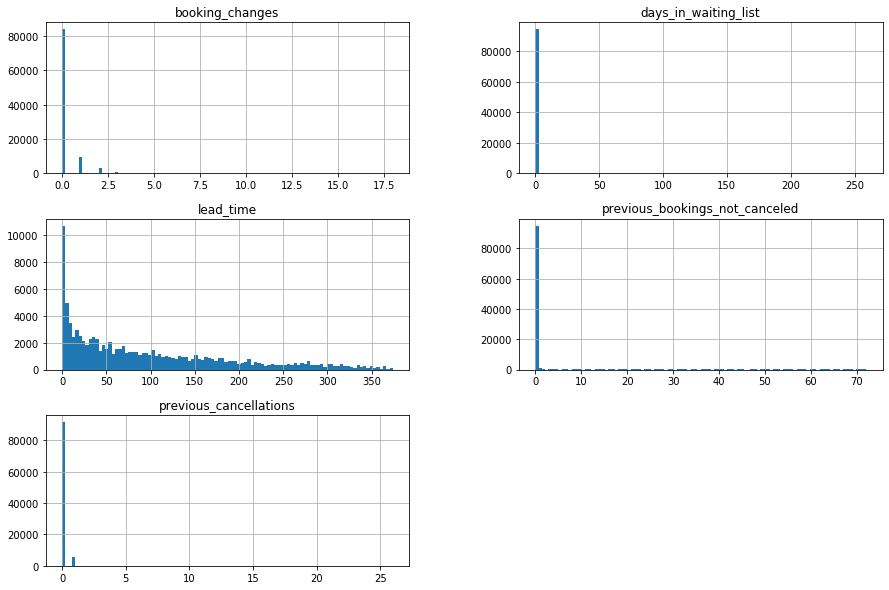

In [113]:
hotel_full[numeric].hist(bins=100, figsize=(15, 10));

Также, посмотрим на диаграмму размаха.

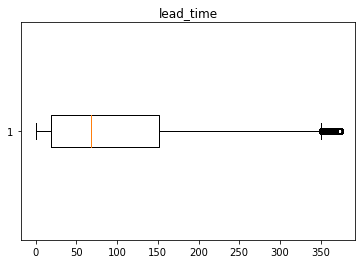

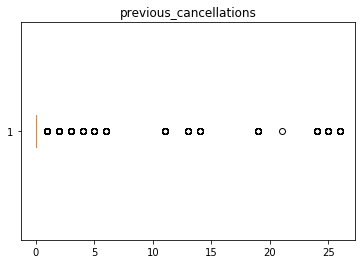

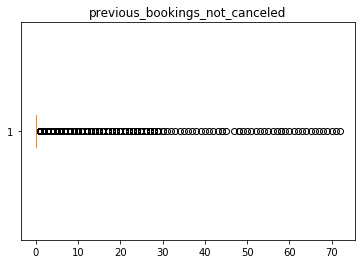

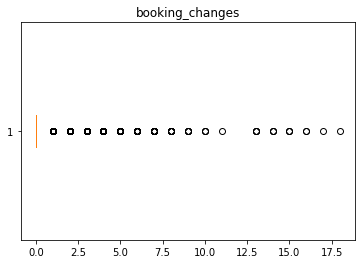

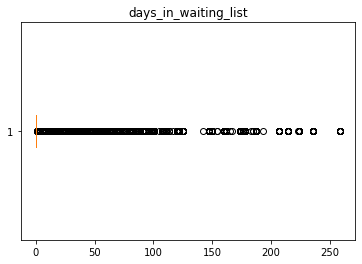

In [114]:
for col in hotel_full[numeric]:
    plt.boxplot(hotel_full[col], vert=False)
    plt.title(col)
    plt.show()

В данных столбцах имеется очень большое количество выбросов.

Посмотрим на средние значения признаков для каждой из категории клиентов.

In [115]:
hotel_full[numeric].join(hotel_full['is_canceled']).groupby('is_canceled').mean().T

is_canceled,0,1
lead_time,75.122972,132.771721
previous_cancellations,0.016146,0.212911
previous_bookings_not_canceled,0.191375,0.024758
booking_changes,0.268203,0.091033
days_in_waiting_list,1.600187,3.504381


Можно заметить, что у гостей, которые отменяли бронь по сравнению с гостями, которые бронь подтвердили:
- Среднее количество дней между датой бронирования и датой прибытия практически в 2 раза больше (132.7 дней)
- В 20 раз выше среднее количество предыдущих отмен бронирования
- В 10 раз ниже среднее количество предыдущих подтвержденных бронирований
- В 2,6 раз ниже среднее количество изменений в параметрах заказа.
- В 2 раза дольше в среднем их заказ ожидал подтвержения

2. Посмотрим на распределение признаков, которые выражены булевым значением.

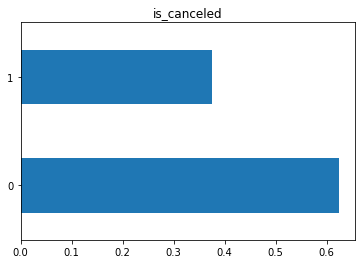

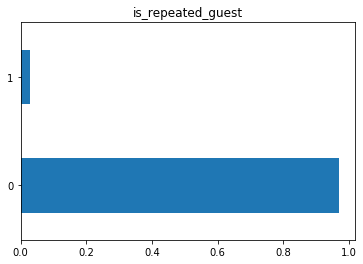

In [116]:
for column in hotel_full[bools].columns:
    hotel_full[column].value_counts(normalize=True).plot.barh(title=column)
    plt.show()

In [117]:
hotel_full[bools].groupby('is_repeated_guest').sum()

,is_canceled
is_repeated_guest,
0,36139
1,496


Можно увидеть, что наибольшее количество отмен наблюдается среди гостей, которые являются первичными клиентами отеля.

Посмотрим также чему **доля** отмен бронирований среди первичных клиентов отеля.

In [118]:
(
    hotel_full[bools].groupby('is_repeated_guest')
    .agg(['sum', lambda x: x.sum() / x.count()])
    .rename(columns={'<lambda_0>': 'share'})
)

is_canceled          
                          sum     share
is_repeated_guest                      
0                       36139  0.381000
1                         496  0.177905

3. Посмотрим, есть ли зависимость категориальных признаков с целевой переменной.

In [119]:
# Посмотрим количество уникальных значений признаков, выраженных номинально
hotel_full[categorical].nunique()

meal                      4
country                 174
distribution_channel      4
reserved_room_type        7
customer_type             4
dtype: int64

Посмотрим, как распределены значения признаков в категориях клиентов, которые отменили бронь, и которые бронь подтвердили. Иными словами мы хотим увидеть наиболее часто встречающиеся категории в обоих групп клиентов и сравнить, насколько они отличаются друг от друга.

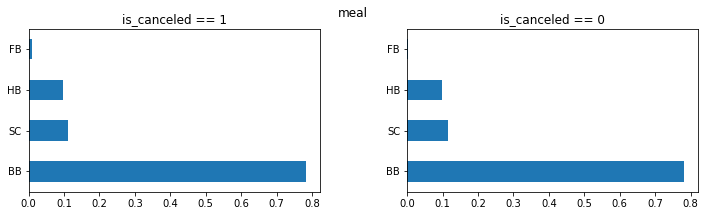

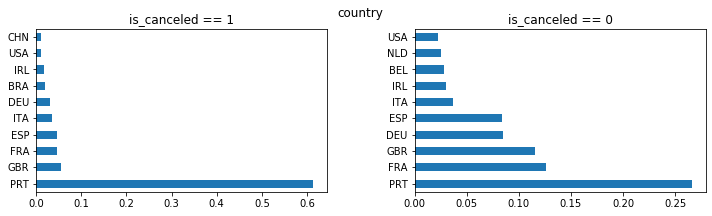

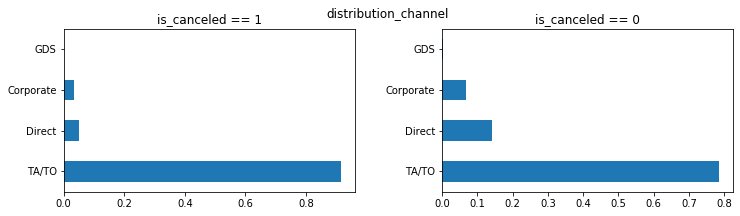

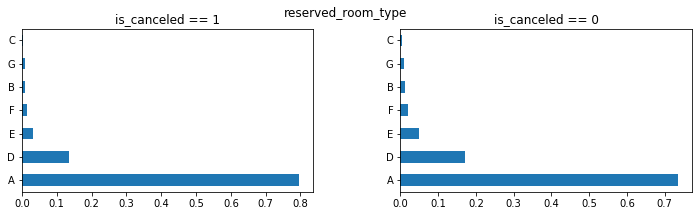

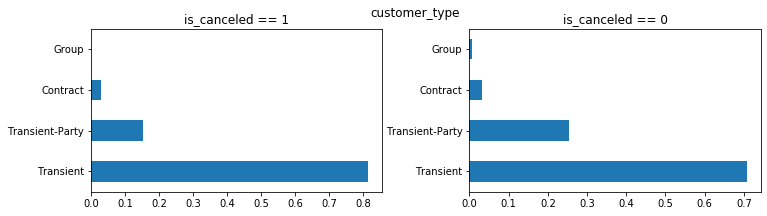

In [120]:
for col in hotel_full[categorical].columns:
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    plt.suptitle(col)
    plt.subplots_adjust(wspace=0.3, hspace=0)
    
    hotel_full[categorical][col][hotel_full['is_canceled'] == 1].value_counts(normalize=True)[:10].plot.barh(
        ax=ax[0], title='is_canceled == 1');
    hotel_full[categorical][col][hotel_full['is_canceled'] == 0].value_counts(normalize=True)[:10].plot.barh(
        ax=ax[1], title='is_canceled == 0');
    
    plt.show()

В целом, какой либо явной зависимости целевой переменной от категориальных признаков выявить не удалось. Распределение категориальных значений примерно одинаковое в каждой группе (в группах клиентов, которые отменили и подтвердили бронь)

4. Посмотрим, есть ли какая-либо тенденция к отменам в зависимости от времени

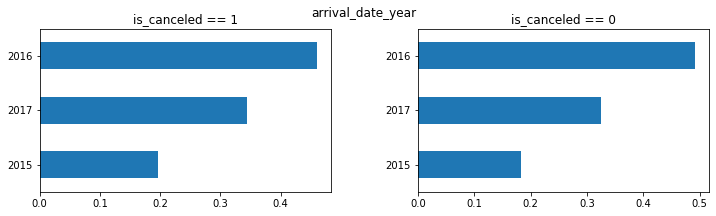

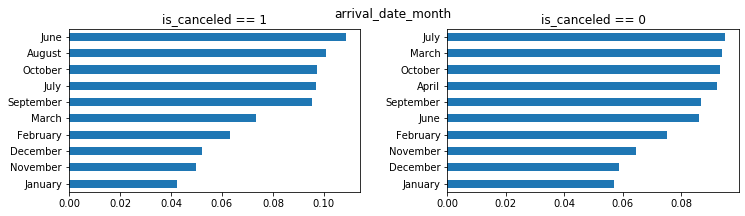

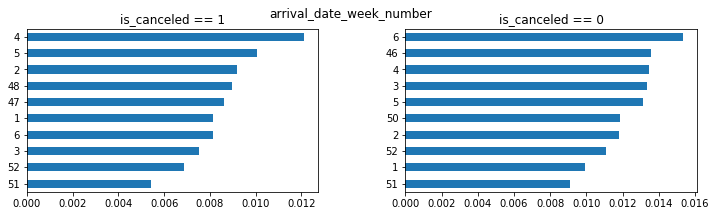

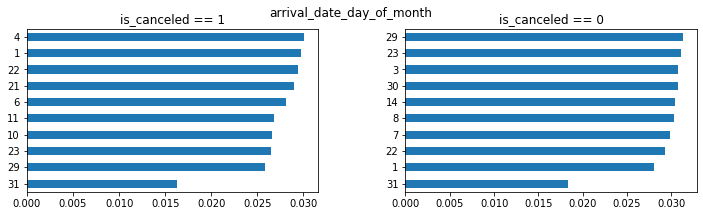

In [121]:
for col in hotel_full[date_time].columns:
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    plt.suptitle(col)
    plt.subplots_adjust(wspace=0.3, hspace=0)
    
    hotel_full[date_time][col][hotel_full['is_canceled'] == 1].value_counts(normalize=True, ascending=True)[:10].plot.barh(
        ax=ax[0], title='is_canceled == 1');
    hotel_full[date_time][col][hotel_full['is_canceled'] == 0].value_counts(normalize=True, ascending=True)[:10].plot.barh(
        ax=ax[1], title='is_canceled == 0');
    
    plt.show()

Похоже, что брони, которые приходились на июнь и август отменялись чаще всего, в то время как брони, которые приходились на июль и март чаще всего подтверждались. Однако, утверждать, что есть какая-либо зависимость отмен от даты заезда очень сложно. 

5. Посмотрим на взаимосвязь признаков из списка "numeric_cat" с целевой переменной.

Посмотрим на средние значения признаков для каждой категории клиентов.

In [122]:
hotel_full[numeric_cat].join(hotel_full['is_canceled']).groupby('is_canceled').mean().T

is_canceled,0,1
stays_in_weekend_nights,0.845622,0.828934
stays_in_week_nights,2.237944,2.304900
adults,1.822772,1.879050
children,0.079697,0.074737
babies,0.008950,0.002866
required_car_parking_spaces,0.085139,0.000000
total_of_special_requests,0.706635,0.318220
total_nights,3.083566,3.133834


У клиентов, которые отменяли бронь, в основном не запрашивали парковочное место, не имели детей до 3х лет, а также среднее количество специалных отметок у них было в 2 раза меньше.  

Однако, стоит также посмотреть на распределение данных признаков.

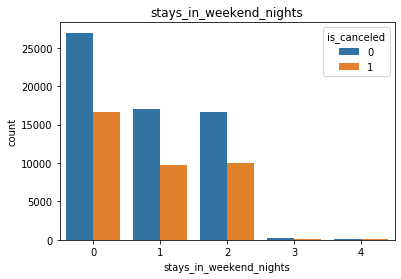

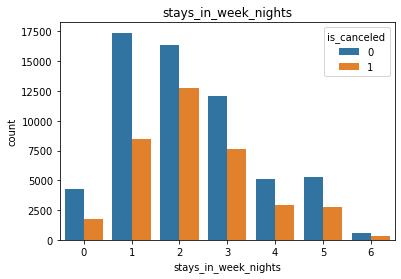

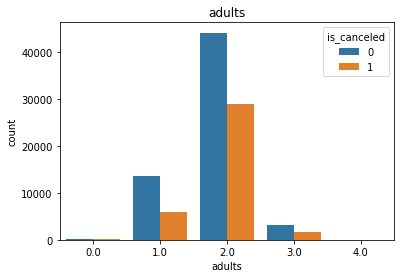

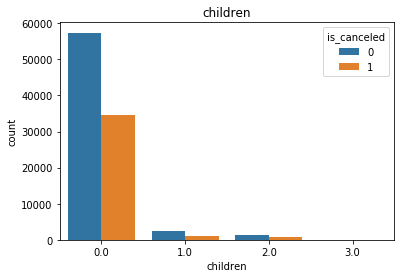

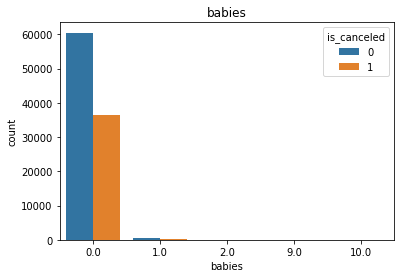

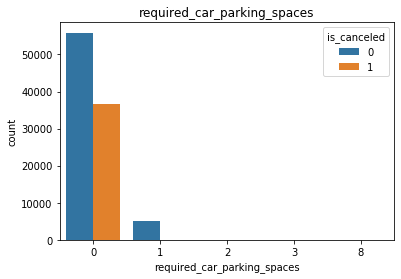

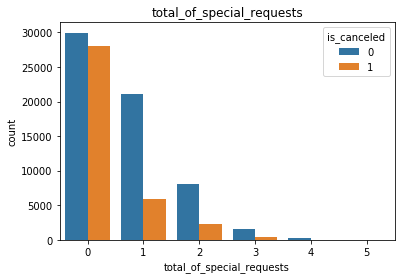

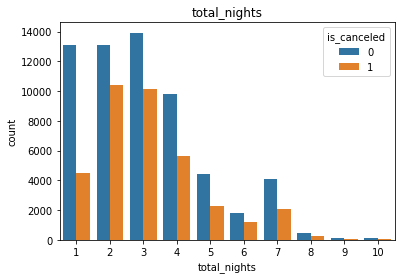

In [123]:
for col in numeric_cat:
    sns.countplot(data=hotel_full[[col, 'is_canceled']], x=col, hue='is_canceled');
    plt.title(col)
    plt.show()

Возможно, разница, которую мы описали выше получена из за разницы в количестве подтвердившихся и отменивших бронь гостей.  
Посмотрим на распределение данных под другим углом.

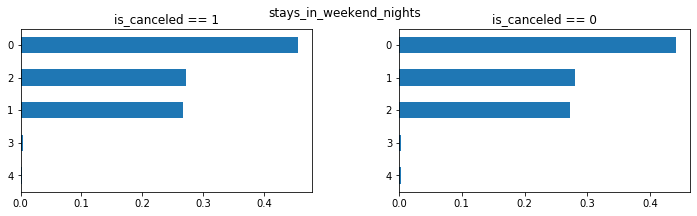

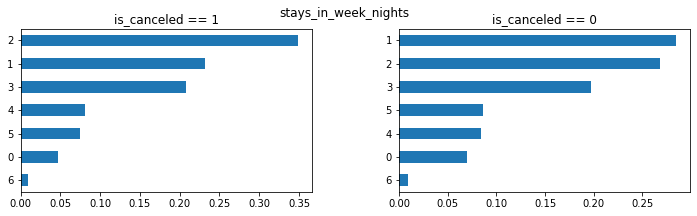

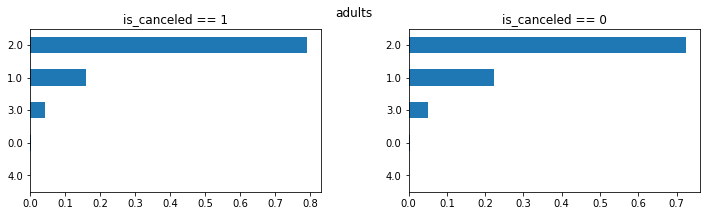

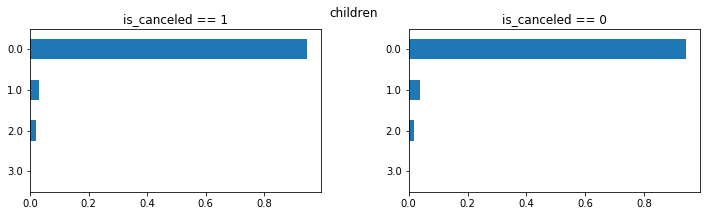

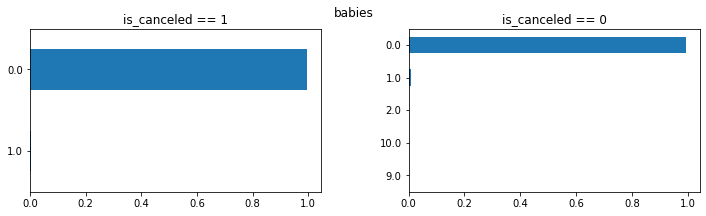

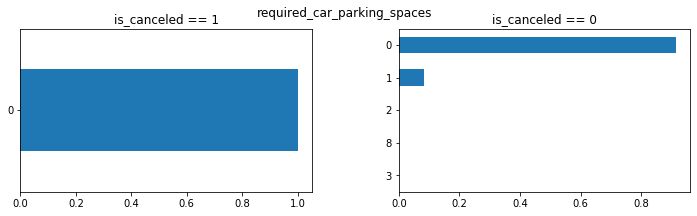

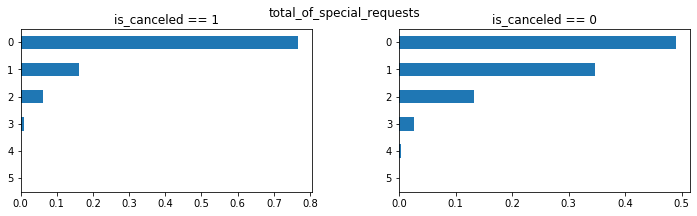

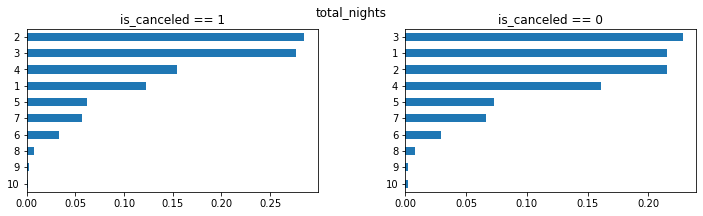

In [124]:
for col in hotel_full[numeric_cat].columns:
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    plt.suptitle(col)
    plt.subplots_adjust(wspace=0.3, hspace=0)
    
    hotel_full[col][hotel_full['is_canceled'] == 1].value_counts(normalize=True,ascending=True).plot.barh(
        ax=ax[0], title='is_canceled == 1');
    hotel_full[col][hotel_full['is_canceled'] == 0].value_counts(normalize=True, ascending=True).plot.barh(
        ax=ax[1], title='is_canceled == 0');
    
    plt.show()

Действительно видно, что значительной вклада в распределение признаков из столбца `numeric_cat` целевой признак не привносит.  

Таким образом, выявить зависимость целевой переменной от признаков столбца `numeric_cat` не удалось.

#### Резюме

В ходе исследовательского анализа, было выявлено, что у клиентов, отменивших бронирование:
- Среднее количество дней между датой бронирования и датой прибытия практически в 2 раза больше (132.7 дней) нежели у подтвердившихся гостей.
- В 20 раз выше среднее количество предыдущих отмен бронирования
- В 10 раз ниже среднее количество предыдущих подтвержденных бронирований
- В 2,6 раз ниже среднее количество изменений в параметрах заказа.
- В 2 раза дольше в среднем их заказ ожидал подтвержения.  

Также, следует отметить, что клиенты, которые впервые обратились в гостиницу отменяли бронь чаще, нежели повторные клиенты.  
Однако следует помнить, что это первичный анализ, которые проводился без соответсвующих статистических методов проверки гипотез, поэтому выводы, которые сделаны являются лишь предположениями на основе наблюдений.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Сначала вычислим прибыль или убыток, которую принес каждый клиент. Создадим соответсвующий столбец.  
Для тестового датасета расчитаем прибыль, которую отель получил без внедрения модели.

Создадим необходимые столбцы для расчета прибыли.  
Для этого, создадим словари, которые понадобятся нам для дальнейшей работы.

In [125]:
# Цена за номер каждой категории
prices = {'A': 1000,
          'B': 800,
          'C': 600,
          'D': 550,
          'E': 500,
          'F': 450,
          'G': 350}

# Стоимость обслуживания номера каждой категории
serv_cost = {'A': 400,
             'B': 350,
             'C': 350,
             'D': 150,
             'E': 150,
             'F': 150,
             'G': 150}

# Сезонный коэффициент
coef = {'January': 1,
        'February': 1,
        'March': 1.2,
        'April': 1.2,
        'May': 1.2,
        'June': 1.4,
        'July': 1.4,
        'August': 1.4,
        'September': 1.2,
        'October': 1.2,
        'November': 1.2,
        'December': 1
} 

# Сезонный коэффициент с номерами месяцев
coef_num = {1: 1,
            2: 1,
            3: 1.2,
            4: 1.2,
            5: 1.2,
            6: 1.4,
            7: 1.4,
            8: 1.4,
            9: 1.2,
            10: 1.2,
            11: 1.2,
            12: 1
}

# Название месяцев и их порядковые номера
months_dict = {'January': 1,
               'February': 2,
               'March': 3,
               'April': 4,
               'May': 5,
               'June': 6,
               'July': 7,
               'August': 8,
               'September': 9,
               'October': 10,
               'November': 11,
               'December': 12
              }

Создадим новые стобцы на основании заданных в задаче условий.

In [126]:
# Столбец с ценами
hotel_full['prices'] = hotel_full['reserved_room_type'].apply(lambda x: prices[x])

# Столбец со стоимостью обслуживания номера
hotel_full['serv_cost'] = hotel_full['reserved_room_type'].apply(lambda x: serv_cost[x])

# Столбец с сезонными коэффициентами
hotel_full['coef'] = hotel_full['arrival_date_month'].apply(lambda x: coef[x])

hotel_full.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,prices,serv_cost,coef
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.4
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2,1000,400,1.4
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2,600,350,1.4
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2,600,350,1.4
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3,1000,400,1.4


Создадим функцию, которая будет расчитывать количество ночей в каждом месяце.

In [127]:
def get_durations(start_date, end_date):
    current = start_date
    result = [current]

    current = current.replace(day=1)
    while current <= end_date:
        current += timedelta(days=32)
        current = current.replace(day=1)
        result.append(datetime(current.year, current.month, 1).date())

    durations= []
    for curr in result[:-1]:
        curr_range = calendar.monthrange(curr.year, curr.month)
        curr_duration = (curr_range[1] - curr.day)+1

        if ((curr.month == end_date.month) & (curr.year == end_date.year)):
            durations.append(end_date.day)
        else:
            durations.append(curr_duration)
            
    if len(durations) > 1:
        durations[-1] -= 1
    elif len(durations) == 1:
        durations[0] -= 1
        
    return durations

In [128]:
# Создадим столбец с месяцем прибытия в формате номера
hotel_full['arrival_date_month_num'] = hotel_full['arrival_date_month'].apply(lambda x: months_dict[x])

# Создадим столбец с датой прибытия
hotel_full['arrival_date'] = pd.to_datetime(dict(year=hotel_full.arrival_date_year, 
                                                 month=hotel_full.arrival_date_month_num, 
                                                 day=hotel_full.arrival_date_day_of_month)
)

# Создадим столбец с датой выезда
hotel_full['departure_date'] = (hotel_full['arrival_date'] + 
                                pd.to_timedelta(hotel_full['total_nights'], unit='D'))

# Создадим столбец с количество ночей, которые гость провел в каждом месяце прибывания
hotel_full['nights_by_month'] = hotel_full[['departure_date', 'arrival_date']].apply(
    lambda row: get_durations(row['arrival_date'], row['departure_date']) , axis=1)

In [129]:
hotel_full.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,prices,serv_cost,coef,arrival_date_month_num,arrival_date,departure_date,nights_by_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.4,7,2015-07-01,2015-07-02,[1]
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2,1000,400,1.4,7,2015-07-01,2015-07-03,[2]
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2,600,350,1.4,7,2015-07-01,2015-07-03,[2]
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2,600,350,1.4,7,2015-07-01,2015-07-03,[2]
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3,1000,400,1.4,7,2015-07-01,2015-07-04,[3]


Создадим функцию, которая будет рассчитывать выручку отеля.

In [130]:
def calculate_revenue(df):
    list_rev = []
    for i in df.index:
        if len(df.loc[i, 'nights_by_month']) == 2: 
            rev = (
                (
                    df.loc[i, 'nights_by_month'][0] * 
                    df.loc[i, 'prices'] * 
                    df.loc[i, 'coef'] * 
                    (df.loc[i, 'is_canceled'] == 0)
                ) + 
                (
                    df.loc[i, 'nights_by_month'][1] * 
                    df.loc[i, 'prices'] * 
                    # Добавил вызов словаря coef_num
                    coef_num[((df.loc[i, 'arrival_date_month_num'] + 1) 
                              if df.loc[i, 'arrival_date_month_num'] < 12 
                              else 1)] * 
                    (df.loc[i, 'is_canceled'] == 0)
                )
            )

        else:
            rev = (
                df.loc[i, 'prices'] * 
                df.loc[i, 'coef'] * 
                df.loc[i, 'total_nights'] * 
                (df.loc[i, 'is_canceled'] == 0)
            )
        list_rev.append(rev)

    return list_rev

Создадим столбец `real_revenue`, в который сохраним выручку отеля с каждого гостя.

In [131]:
hotel_full['real_revenue'] = calculate_revenue(hotel_full)

Создадим функцию для подсчета совокупных затрат.

In [132]:
def calculate_total_costs(df):
    if df['is_canceled'] == 0:
        total_costs = (df['total_nights'] // 2 * 
                       df['serv_cost'] + 
                       df['serv_cost'])
    else:
        total_costs = df['serv_cost']
    return total_costs

In [133]:
# Создадим столбец, в который сохраним совокупные затраты на обслуживание номера
hotel_full['total_costs'] = hotel_full.apply(calculate_total_costs, axis=1)

# Создадим столбец, в который сохраним чистую прибыль от каждого гостя.
hotel_full['profit'] = hotel_full['real_revenue'] - hotel_full['total_costs']

# Выведем на экран первым 5 строк новой таблицы
hotel_full.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,prices,serv_cost,coef,arrival_date_month_num,arrival_date,departure_date,nights_by_month,real_revenue,total_costs,profit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.4,7,2015-07-01,2015-07-02,[1],1400.0,400,1000.0
1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2,1000,400,1.4,7,2015-07-01,2015-07-03,[2],2800.0,800,2000.0
2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2,600,350,1.4,7,2015-07-01,2015-07-03,[2],1680.0,700,980.0
3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2,600,350,1.4,7,2015-07-01,2015-07-03,[2],1680.0,700,980.0
4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3,1000,400,1.4,7,2015-07-01,2015-07-04,[3],0.0,400,-400.0


Нам нужно, чтобы в тестовом датасете были данные за 1 год. Тогда мы сможем оценить прибыль отеля за 1 год.  
Посмотрим, какое количество данных содержится в наших таблицах.

In [134]:
# Вся таблица
hotel_full.groupby('arrival_date_year')['arrival_date_day_of_month'].count()

arrival_date_year
2015    18328
2016    46901
2017    32412
Name: arrival_date_day_of_month, dtype: int64

In [135]:
# Тренировочный датасет
hotel_train.groupby('arrival_date_year')['arrival_date_day_of_month'].count()

arrival_date_year
2015    18328
2016    46901
Name: arrival_date_day_of_month, dtype: int64

In [136]:
# Тестовый датасет
hotel_test.groupby('arrival_date_year')['arrival_date_day_of_month'].count()

arrival_date_year
2017    32412
Name: arrival_date_day_of_month, dtype: int64

Отлично. Получается, что в тренировочном датасете у нас есть данные за 2015 и 2016 года, а в тестовом данные за 2017 год. Ровно так, как нам и нужно.

Для тестового датасета расчитаем прибыль, которую отель получил за 2017 год без внедрения модели.

In [137]:
# Проверим на всякий случай, не повторяются ли индексы в тренировочном и тестовом датасетах
print("Повторяющихся индексов:", (hotel_test.index).isin(hotel_train.index).sum())

Повторяющихся индексов: 0


Посчитаем прибыль для 2017 года без внедрения модели (тестовый набор данных)

In [138]:
profit_before = hotel_test.join(hotel_full['profit'])['profit'].sum()

print('Прибыль отеля за 2017 год без внедрения модели:', profit_before, 'руб.')

Прибыль отеля за 2017 год без внедрения модели: 46383850.0 руб.


### Шаг 4. Разработка модели ML

#### Описание задачи

Разработаем ML модель, которая будет предсказывать отказ клиенты от брони.  
Будем решать задачу бинарной классификации.

Посмотрим, как распределен целевой признак 'is_canceled'

In [139]:
hotel_train['is_canceled'].value_counts(normalize=True)

0    0.631391
1    0.368609
Name: is_canceled, dtype: float64

Классы сбалансированы. (Дисбаланс классов считаем при доле одного из классов менее 25%)

Метрика для задачи выберем: f1_score. В данной задаче нам важна как полнота предсказаний модели (важно, чтобы модель могла распознать как можно больше клиентов, которые отменили бронь), так и ее точность (важно, чтобы среди тех клиентов, которых модель пометила как ненадежных, как можно больше действительно таковыми бы являлись).

#### Подбор модели

Для начала преобразуем признак `country`. В этом столбце 174 уникальных значения. Посмотрим, как часто встречается каждая из стран. Выведем на экран топ 20.

In [140]:
pd.concat([hotel_train, hotel_test])['country'].value_counts()[:20]

PRT    38718
FRA     9451
GBR     9036
ESP     6832
DEU     6265
ITA     3480
IRL     2505
BEL     2127
BRA     1969
NLD     1875
USA     1782
CHE     1476
AUT     1155
CN       957
CHN      921
SWE      862
POL      770
ISR      639
RUS      513
NOR      503
Name: country, dtype: int64

Страны, которые встречаются менее 1000 раз назовем категорией 'Others'.  
Соответсвенно, когда мы будем передавать модель в продакшн, нам необходимо будет, чтобы данные поступали нам именно в таком формате. Для этого можно изменить варианты выбора страны в форме, которую заполняет клиент при бронировании. Либо же добавить этап предобработки данных, на котором все страны, не входящие в наиболее встречающиеся были отмечены как 'Others'.

In [141]:
top_10 = pd.concat([hotel_train, hotel_test])['country'].value_counts()[lambda x: x >= 1000]
list_top_10 = list(top_10.to_dict().keys())
list_top_10

['PRT',
 'FRA',
 'GBR',
 'ESP',
 'DEU',
 'ITA',
 'IRL',
 'BEL',
 'BRA',
 'NLD',
 'USA',
 'CHE',
 'AUT']

Преобразуем столбец `country` таким образом, что все не входящие в список `top_10` страны были переименованы в категорию `others`

In [142]:
hotel_train['country'] = hotel_train['country'].where(lambda x: x.isin(list_top_10), 'Others')
hotel_test['country'] = hotel_test['country'].where(lambda x: x.isin(list_top_10), 'Others')

Разделим тренировочную и тестовую выборки на признаки для обучения и целевую переменную

In [143]:
train_X = hotel_train.drop('is_canceled', axis=1)
train_y = hotel_train['is_canceled']

test_X = hotel_test.drop('is_canceled', axis=1)
test_y = hotel_test['is_canceled']


train_X.shape, train_y.shape, test_X.shape, test_y.shape

((65229, 23), (65229,), (32412, 23), (32412,))

In [144]:
train_X.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
id,,,,,,,,,,,,,,,,,,,,,,,
0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


Проверим, все ли уникальные значения из столбцов с форматом хранения данных `object` присутствуют в тренировочом и тестовом наборе данных

In [145]:
for col in test_X.select_dtypes(include='object').columns:
    if train_X[col].nunique() == test_X[col].nunique():
        print(f'Количество значений столбца {col} совпадают в тренировочном и тестовом наборе данных')
        
        if sorted(list(train_X[col].unique())) == sorted(list(test_X[col].unique())):
            print(f'Уникальные значения столбца {col} совпадают в тренировочном и тестовом наборе данных')
        else:
            print(f'Уникальные значения столбца {col} различаются в тренировочном и тестовом наборе данных')
            print(
                'Есть в трейне, но нет в тесте:', [c for c in train_X[col].unique() if c not in list(test_X[col].unique())])
            print(
                'Есть в тесте, но нет в трейне:', [c for c in test_X[col].unique() if c not in list(train_X[col].unique())])
        print('--------')
    else:
        print(f'!!! Количество значений столбца {col} различаются в тренировочном и тестовом наборе данных')

        print('Есть в трейне, но нет в тесте:', [c for c in train_X[col].unique() if c not in list(test_X[col].unique())])
        print('Есть в тесте, но нет в трейне:', [c for c in test_X[col].unique() if c not in list(train_X[col].unique())])
        print('--------')

!!! Количество значений столбца arrival_date_month различаются в тренировочном и тестовом наборе данных
Есть в трейне, но нет в тесте: ['September', 'October', 'November', 'December']
Есть в тесте, но нет в трейне: []
--------
Количество значений столбца meal совпадают в тренировочном и тестовом наборе данных
Уникальные значения столбца meal совпадают в тренировочном и тестовом наборе данных
--------
Количество значений столбца country совпадают в тренировочном и тестовом наборе данных
Уникальные значения столбца country совпадают в тренировочном и тестовом наборе данных
--------
Количество значений столбца distribution_channel совпадают в тренировочном и тестовом наборе данных
Уникальные значения столбца distribution_channel совпадают в тренировочном и тестовом наборе данных
--------
Количество значений столбца reserved_room_type совпадают в тренировочном и тестовом наборе данных
Уникальные значения столбца reserved_room_type совпадают в тренировочном и тестовом наборе данных
--------

С признаками все в порядке. Можно переходить дальше.

Первый этап - необходимо создать пайплайн предобработки данных.

`arrival_date_year` - удалить, так как этот признак будет совершенно иным в тестовом наборе данных. Соответсвенно, не имеет смысла вводить год в качестве признака.  
`arrival_date_month` - преобразуем с помощью OrdinalEncoding.
`meal` - преобразуем с помощью OneHotEncoder  
`country` - преобразуем с помощью OneHotEncoder.  
`distribution_channel` - преобразуем с помощью OneHotEncoder  
`reserved_room_type` - преобразуем с помощью OrdinalEncoding (у категорий комнат есть порядок).  
`customer_type` - преобразуем с помощью OneHotEncoder   

Численные призаки нормализуем с помощью `RobustScaler`, так как он наиболее устойчив к выбросам.

In [149]:
# Зададим необходимый нам порядок для категориальных столбцов
reserved_room_type_order = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
arrival_date_month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Создадим список столбцов для OneHot-кодирования
one_hot_columns = ['meal', 'distribution_channel', 'customer_type', 'country']

In [150]:
# Зададим необходимый нам порядок для категориальных столбцов
reserved_room_type_order = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
arrival_date_month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Создадим список столбцов для OneHot-кодирования
one_hot_columns = ['meal', 'distribution_channel', 'customer_type', 'country']

In [151]:
# Создадим класс, который будет удалять столбцы
class columnDropperTransformer():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self 


# Создадим объект типа ColumnTransformer
col_transform = ColumnTransformer([
    ('one_hot_encode', OneHotEncoder(drop='first', sparse=False), one_hot_columns), 
    ('ordinal_encode_reserved_room_type', OrdinalEncoder(categories=[reserved_room_type_order]), ['reserved_room_type']), 
    ('ordinal_encode_arrival_date_month', OrdinalEncoder(categories=[arrival_date_month_order]), ['arrival_date_month'])
], remainder='passthrough'
)

# Создадим pipeline предобработки данных.
preprocessing_pipe = Pipeline([
    ('delete_column', columnDropperTransformer('arrival_date_year')), 
    ('transform_columns', col_transform), 
    ('robust_scaler', RobustScaler())
])

Обучим наш pipeline предобработки данных на тренировочном наборе.

In [152]:
preprocessing_pipe.fit(train_X)

Pipeline(memory=None,
         steps=[('delete_column',
                 <__main__.columnDropperTransformer object at 0x7facb3440190>),
                ('transform_columns',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('one_hot_encode',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop='first',
                                                                dtype=<class 'numpy.float...
                                                 ('ordinal_encode_arrival_date_month',
                                                  OrdinalEncoder(categories=[['January',
                                                

Для начала посмотрим на результаты некоторых моделей с минимальными настройками гиперпараметров (либо с настройками по умолчанию)

In [153]:
models_basic_results = pd.DataFrame()

dummy = DummyClassifier(random_state=1)
sgd = SGDClassifier(class_weight='balanced', random_state=1)
log_reg = LogisticRegression(class_weight='balanced', random_state=1)
random_forest = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
svc = LinearSVC(random_state=1)
xgbt = XGBClassifier(booster='gbtree', random_state=1)
xgbl = XGBClassifier(booster='gblinear', random_state=1)
xgbd = XGBClassifier(booster='dart', random_state=1)

In [156]:
models_dict = {'Dummy': dummy, 
               'SGDClassifier': sgd, 
               'LogisticRegression': log_reg, 
               'RandomForestClassifier': random_forest, 
               'LinearSVC': svc, 
               'XGBClassifierTree': xgbt, 
               'XGBClassifierLinear': xgbl,
               'XGBClassifierDart': xgbd}

for name, model in tqdm(models_dict.items()):
    score = cross_val_score(
        model,
        preprocessing_pipe.transform(train_X), 
        train_y,
        scoring='f1',
#         cv=5
        cv=3
        )
    models_basic_results[name] = [score.mean()]

100%|██████████| 8/8 [02:03<00:00, 15.43s/it]


In [157]:
models_basic_results.T.sort_values(by=0, ascending=False)

,0
LogisticRegression,0.639406
LinearSVC,0.613351
SGDClassifier,0.603968
XGBClassifierTree,0.573379
XGBClassifierDart,0.573379
RandomForestClassifier,0.490630
Dummy,0.365665
XGBClassifierLinear,0.083190


Наилучший результат показала модель Логистической регрессии (f1_score=63,5%).  
Возмем эту модель и подберем гиперпараметры на кросс-валидации.

In [158]:
# Гиперпараметры для регулярищации L2
params_rand = {'C': [0.1, 0.5, 1, 5, 10], 
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']}
#                'warm_start': [True, False]}

# Гиперпараметры для регулярищации L1
params_rand_l1 = {'penalty': ['l1'],
                  'C': [0.1, 0.5, 1, 5, 10], 
                  'solver': ['liblinear', 'saga']}
#                   'warm_start': [True, False]}

# Гиперпараметры для регуляризации ElasticNet
params_rand_elasticnet = {'penalty': ['elasticnet'],
                           'C': [0.1, 0.5, 1, 5, 10], 
                           'solver': ['saga'], 
#                            'warm_start': [True, False], 
                           'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9] }

In [159]:
# Подбор гиперпараметров для модели с регуляризацией L2
model_rand = RandomizedSearchCV(log_reg,
                                params_rand,
                                scoring='f1',
                                cv=3,
                                verbose=1,
                                random_state=1)

model_rand.fit(preprocessing_pipe.transform(train_X), train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=1,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1, 5, 10],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'saga']},
                   pre_dispatch='2*n_jobs', random_stat

In [160]:
# Подбор гиперпараметров для модели с регуляризацией L1
model_rand_l1 = RandomizedSearchCV(log_reg,
                                params_rand_l1,
                                scoring='f1',
                                cv=3,
                                verbose=1,
                                random_state=1)

model_rand_l1.fit(preprocessing_pipe.transform(train_X), train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=1,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1, 5, 10],
                                        'penalty': ['l1'],
                                        'solver': ['liblinear', 'saga']},
                   pre_dispatch='2*n_jobs', random_state=1, refit=Tru

In [161]:
# Подбор гиперпараметров для модели с регуляризацией ElasticNet
model_rand_elasticnet = RandomizedSearchCV(log_reg,
                                params_rand_elasticnet,
                                scoring='f1',
                                cv=3,
                                verbose=1,
                                random_state=1)

model_rand_elasticnet.fit(preprocessing_pipe.transform(train_X), train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=1,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1, 5, 10],
                                        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                                        'penalty': ['elasticnet'],
                                        'solver': ['saga

In [162]:
print('L2-регуляризация, f1_score:', model_rand.best_score_)
print('L1-регуляризация, f1_score:', model_rand_l1.best_score_)
print('ElasticNet-регуляризация, f1_score:', model_rand_elasticnet.best_score_)

L2-регуляризация, f1_score: 0.6426297488622073
L1-регуляризация, f1_score: 0.6420506251400884
ElasticNet-регуляризация, f1_score: 0.6331482931245428


Модель с L2-регуляризацией показала наилуший результат на кроссвалидации.

Посмотрим на ее гиперпараметры.

In [163]:
model_rand.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Используем ее для предсказаний на тестовой выборке. Сохраним получившуюся модель в переменную `best_model`

In [164]:
best_model = model_rand.best_estimator_

#### Проверка на тестовой выборке

In [165]:
# Создадим пайплайн для одновременной предобработки данных и предсказания модели.
best_model_pipe = Pipeline([('preprocess', preprocessing_pipe), 
                            ('model', best_model)])

In [166]:
# Сделаем предсказания на тестовой выборке и сохраним их в переменной predictions
predictions = best_model_pipe.predict(test_X)

# Вычислим f1_score модели на тестовой выборке
f1_score(test_y, predictions)

0.6738190421799788

На тестовой выборке мы получили f1_score даже выше, чем на тренировочной кросс-валидации: 67,38%

Построим графики precision-recall и roc_auc кривую.

In [167]:
# Зададим функцию, которая построит график Precision-Recall
def precision_recall_plot(title=None, model=None, X=None, y=None, ax=None):
    probabilities_valid = model.predict_proba(X)
    precision, recall, thresholds = precision_recall_curve(y, probabilities_valid[:, 1])

    ax.step(recall, precision, where='post')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    ax.grid()
    
# Зададим функцию, которая построит график ROC_AUC
def roc_curve_plot(title='ROC-кривая', model=None, X=None, y=None, ax=None):
    probabilities_valid = model.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probabilities_valid[:, 1]) 
    
    ax.step(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    ax.grid()

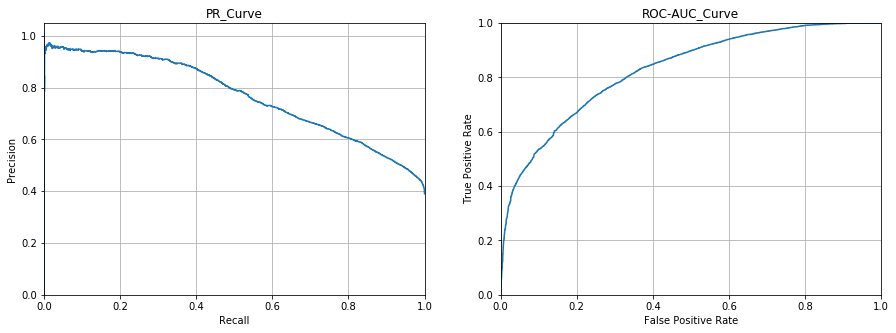

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Строим кривую Precision-Recall
precision_recall_plot('PR_Curve', best_model_pipe, test_X, test_y, ax[0])

# Строим кривую AUC-ROC
roc_curve_plot('ROC-AUC_Curve', best_model_pipe, test_X, test_y, ax[1])

In [169]:
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80     19821
           1       0.69      0.66      0.67     12591

    accuracy                           0.75     32412
   macro avg       0.74      0.74      0.74     32412
weighted avg       0.75      0.75      0.75     32412



Модель распознает 66% ненадежных клиентов из всех ненадежных клиентов.  
При этом, из тех, кого модель отметила как ненадежного клиента, 31% окажутся на самом деле надежными.

#### Оценим прибыль, которую получит отель при использовании модели за год

Создадим таблицу `profit_table`, в которую сохраним все необходимые значения.

In [170]:
profit_table = test_X.join(hotel_full[['prices', 'coef', 'serv_cost', 'profit', 'is_canceled']])

profit_table['predictions'] = predictions
profit_table['deposit'] = ((profit_table['prices'] * profit_table['coef'] + 
                            profit_table['serv_cost']) * 0.8 * 
                            profit_table['predictions'])


# Создадим столбец 'profit_after' и заполним его NaN
profit_table['profit_after'] = [np.nan] * profit_table.shape[0]
    
# Заполним столбец 'profit_after' необходимыми значениями
profit_table['profit_after'] = (profit_table['profit_after']
                                # Строки клиентов, которые действительно отменили свою бронь 
                                 # заполним значениями из столбца 'deposit' за вычетом стоимости уборки 'serv_cost'.
                                .where(profit_table['is_canceled'] == 0, profit_table['deposit'] - profit_table['serv_cost'])
                                
                                # Строки клиентов, которые подтвердились и полностью оплатили 
                                # свое проживание заполним значениями из столбца 'profit'
                                .fillna(profit_table['profit'])
)

In [171]:
profit_table.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,prices,coef,serv_cost,profit,is_canceled,predictions,deposit,profit_after
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6086,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,1.0,400,-400.0,1,1,1120.0,720.0
6087,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,-400.0,1,0,0.0,-400.0
6088,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,-400.0,1,0,0.0,-400.0
6089,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,1.0,400,-400.0,1,1,1120.0,720.0
6090,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,1.0,400,-400.0,1,1,1120.0,720.0


In [172]:
profit_after = profit_table['profit_after'].sum()

print('Прибыль отеля за 2017 год после внедрения модели:', profit_after, 'руб.')
print('Дополнительная прибыль, которую модель принесла отелю за 2017 год:', profit_after - profit_before)
print('Дополнительная прибыль, которую отель получил от внедрения модели за вычетом расходов на внедрение:', profit_after - profit_before - 400000)

Прибыль отеля за 2017 год после внедрения модели: 56083946.0 руб.
Дополнительная прибыль, которую модель принесла отелю за 2017 год: 9700096.0
Дополнительная прибыль, которую отель получил от внедрения модели за вычетом расходов на внедрение: 9300096.0


#### Резюме

Благодаря внедрению модели отель мог заработать 9 300 096 рублей дополнительно к той прибыли, которую получил в 2017 году.

### Шаг 5. Опишите портрет «ненадёжного» клиента

В ходе исследовательского анализа, было выявлено, что у клиентов, отменивших бронирование:
- Среднее количество дней между датой бронирования и датой прибытия практически в 2 раза больше (132.7 дней) нежели у подтвердившихся гостей.
- В 20 раз выше среднее количество предыдущих отмен бронирования
- В 10 раз ниже среднее количество предыдущих подтвержденных бронирований
- В 2,6 раз ниже среднее количество изменений в параметрах заказа.
- В 2 раза дольше в среднем их заказ ожидал подтвержения.  

Также, следует отметить, что клиенты, которые впервые обратились в гостиницу отменяли бронь чаще, нежели повторные клиенты.  
Однако следует помнить, что это первичный анализ, которые проводился без соответсвующих статистических методов проверки гипотез, поэтому выводы, которые сделаны являются лишь предположениями на основе наблюдений.

Для того, чтобы дать финальное заключение, изучим важность признаков в модели. Для этого первым делом создадим список признаков нашей выборки, и затем начертим график, на котором каждому признаку будет соответсвовать коэффициент логистической регрессии.

In [173]:
# Извлечем список столбцов, преобразованных с помощью OneHotEncoder
ohe_columns_after_pp = list(col_transform.transformers_[0][1].get_feature_names())

# Создадим список столбцов, которые остались после преобразований OneHotEncoder и OrdinalEncoder алгоритмами.
columns_left = [col for col in hotel_test.columns if col not in
          (['reserved_room_type', 'arrival_date_month'] + one_hot_columns + ['is_canceled', 'arrival_date_year'])]

# Создадим единый список признаков, которые образовались после предобработки с помощью preprocessing_pipe
features_after_pp = ohe_columns_after_pp + ['reserved_room_type', 'arrival_date_month'] + columns_left

# Проверим количество кожффициентов в модели и количество названий признаков в списке "features_after_pp"
best_model.coef_.shape, np.array([1 for elem in features_after_pp]).shape

((1, 40), (40,))

Построим график.

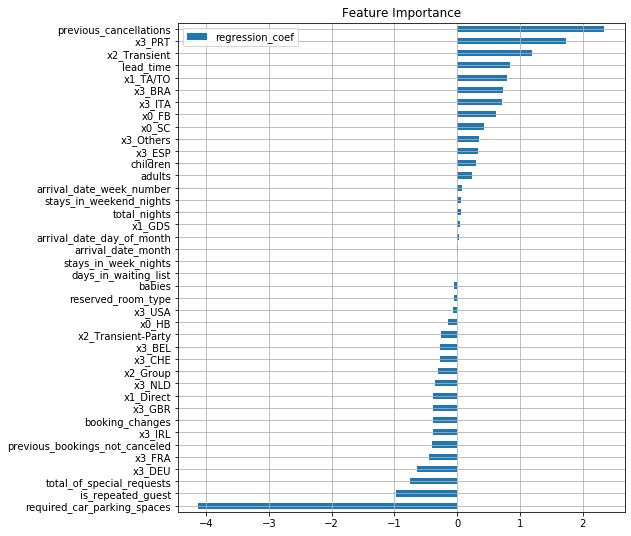

In [174]:
(
    pd.DataFrame(best_model.coef_, columns=features_after_pp).T
    .sort_values(by=0, ascending=True).
    plot.barh(grid=True, figsize=(8, 9), title='Feature Importance')
);
plt.legend(['regression_coef']);

В соответствии с коэффициентами логистической регрессии, можно утверждать, что признаками, которые вносят наибольший вклад в модель являются (прямая зависимость):
- `previous_cancellations`
- `customer_type=Transient`
- `country=PRT, FRA, BRA`
- `distribution_channel=TA/TO, FB`
Обратная зависимость:
- `is_repeated_guest`
- `required_car_parking_spaces`
- `lead_time`
- `country=DEU`
- `total_of_special_request`.   
 
 
Зависимость между данными признаками следующаю: 
- `previous_cancellations` - чем больше у гостя предыдущих отмен, тем больше вероятность того, что он отменит бронь.
- `country=PRT, FRA, BRA` - если клиент из страны 'PRT', 'FRA' или 'BRA', то он с большей вероятностью отменит бронь.
- `customer_type=Transient` - если тип заказчика относится к классу 'Transient', то он с большей вероятностью аннулирует бронь.
- `is_repeated_guest` - если гость повторный, то он скорее всего подтвердит свою бронь. Соответсвенно, если гость образается впервые, то это увеличивает вероятность отмены.
- `required_car_parking_spaces` - чем меньше клиенту требуется парковочных мест, тем выше вероятность того, что он отменит бронь.
- `lead_time` - чем больше дней между датой бронирования и датой прибытия, тем выше вероятность отмены.
- `distribution_channel=TA/TO, FB` - если клиент пришел из канала TA/TO или FB, то вероятность отмены выше.
- `total_of_special_request` - чем меньше количества специальных отметок у гостя, тем выше вероятность, что он отменит бронь.

На основе всего выше перечисленного, клиента, склонного к отказу от брони можно охарактеризовать следующим образом:  


- **Это человек, который обратился в отель впервые.**  
- **Он из страны PRT, BRA или FRA и ему не требуется парковочное место.**  
- **Также, у него практически отсутствуют специальные отметки.**  
- **Этот тип заказчика не связан с договором или групповым заездом и скорее всего пришел из источника дистрибуции заказов TA/TO или FB.**  
- **При этом, у этого гостя уже было несколько отмен ранее и количество дней от заказа до его прибытия достаточно большое.**

В целом, можно отметить, что ряд гипотез, которые были выдвинуты на этапе исследовательского анализа подтвердились.

### Шаг 6. Напишите общий вывод

В ходе работы были проделаны следующие шаги:  
**1. Данные были открыты и изучены.**
**2. Следующим шагом была произведена предобработка данных и краткий исследовательский анализ**. В ходе исследователького анализа было выявлено, что:
- Средний временной отрезок между бронированием и заселением у отменивших бронь гостей в 2 раза выше (нежели у засешившихся) и составляет 132.7 дней.
- У гостей, отменивших бронирование в 20 раз выше среднее количество предыдущих отмен.
- У гостей, отменивших бронирование в 10 раз ниже среднее количество предыдущих подтвержденных бронирований
- У гостей, отменивших бронирование в 2,6 раз ниже среднее количество изменений в параметрах заказа.
- Заказы, которые сделали гости, впоследствие отменившие бронь, в среднем в 2 раза дольше ожидали подтвержения
- Гости, отменившие бронь в основном были первичными клиентами  
**3. Следующим шагом была сформулирована ML-задача и посчитаны необходимые бизнес-показатели**, в том числе прибыль отеля за 2017 год без внедрения модели: она составила 57 768 990.0 руб
**4. Следующие этап состоял в разработке ML-модели**. На данном шаге мы:  
- Произвели предобработку данных, необходимую для обучения модели
- Проверили точность предсказания 6-и моделей в их  базовой настройке на 3-fold кросс-валидации. Были получены следующие результаты:
|Модель | F1_score |
|--------|----------|
| LogisticRegression|	0.635113
| SGDClassifier	|0.607597
|LinearSVC	|0.603093
|XGBClassifierTree|	0.551118
|XGBClassifierDart|	0.551118
|RandomForestClassifier|	0.473392
|Dummy|	0.369416
|XGBClassifierLinear|	0.057815
- Для модели, показавшей наилучший результат был произведен подбор гиперпараметров методом RandomSearchCV. F1_score наилучшей модели на кросс-валидации достиг 64%.
- Затем, модель была проверена на тестовом наборе данных. Результаты представлены ниже:  
    - F1_score: 67.38%  
|class |precision  |  recall | f1-score  | support|
|------|---------- | ------- |--------- |-------- |
|    0    |   0.79  |    0.82   |   0.80  |   19821|
|    1     |   0.69    |   0.66    |   0.67   |  12591|

    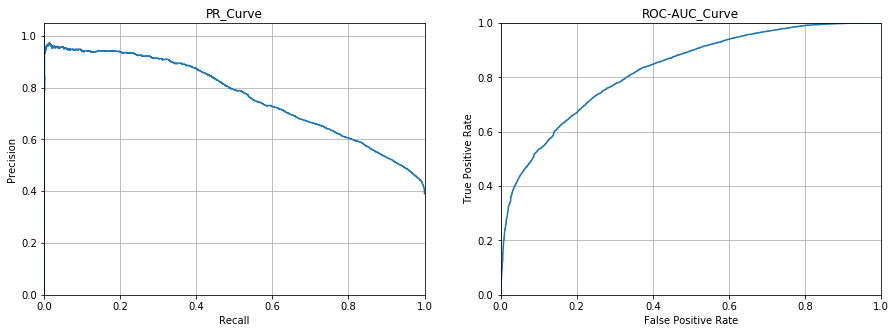
    
**5. Была посчитана прибыль отеля за 2017 год с учетом предсказаний модели и стоимости ее внедрения**:
- Прибыль отеля за 2017 год после внедрения модели: 67 469 086.0 руб.
- Дополнительная прибыль, которую модель принесла отелю за 2017 год: 9 700 096.0
- Дополнительная прибыль, которую отель получил от внедрения модели за вычетом расходов на внедрение: 9 300 096.0

**6. Был найден и визуализирован вклад каждого признака в модель**: 
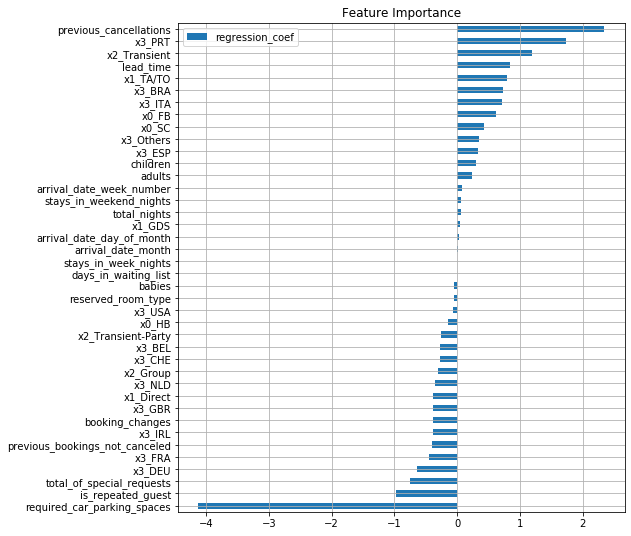
- Среди признаков, которые вносят наибольший вклад в рещультат модели и имеют прямую зависимость с целевым признаком, находятся: 
    - `previous_cancellations`
    - `customer_type=Transient`
    - `country=PRT, FRA, BRA`
    - `distribution_channel=TA/TO, FB`
- Признаки, которые вносят наибольший вклад в результат модели и имеют обратную зависимость с целевым признаком:
    - `is_repeated_guest`
    - `required_car_parking_spaces`
    - `lead_time`
    - `country=DEU`
    - `total_of_special_request`. 
- Такжее был описан примерный портрет "ненадежного гостя, склонного к отменен брони": 
Это человек, который обратился в отель впервые.  
Он из страны PRT, BRA или FRA и ему не требуется парковочное место.  
Также, у него практически отсутствуют специальные отметки.  
Этот тип заказчика не связан с договором или групповым заездом и скорее всего пришел из источника дистрибуции заказов TA/TO или FB.  
При этом, у этого гостя уже было несколько отмен ранее и количество дней от заказа до его прибытия достаточно большое.  

Таким образом, благодаря построению модели машинного обучения, удалось не только определить портрет "ненедежного клиента", но и подсчитать потенциальную прибыль, которую отель может получить от ее внедрения: за 1 календарный год модель способна принести отелю дополнительно  9 300 096 рублей, с учетом стоимости на ее внедрение.

### Полезные ссылки

[How to get the number of Days in a Specific Month between Two Dates in Python](https://stackoverflow.com/questions/45816497/how-to-get-the-number-of-days-in-a-specific-month-between-two-dates-in-python)  
[Which hyperparameter should be tuned in the XGBoost model to improve performance?](https://www.quora.com/Which-hyperparameter-should-be-tuned-in-the-XGBoost-model-to-improve-performance)  
[Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)  
[Best way to find the months between two dates](https://stackoverflow.com/questions/4039879/best-way-to-find-the-months-between-two-dates)  
[How to get the number of Days in a Specific Month between Two Dates in Python](https://stackoverflow.com/questions/45816497/how-to-get-the-number-of-days-in-a-specific-month-between-two-dates-in-python)  
[How to convert columns into one datetime column in pandas?](https://stackoverflow.com/questions/19350806/how-to-convert-columns-into-one-datetime-column-in-pandas)  
[Pandas Dataframes: Apply Examples](https://queirozf.com/entries/pandas-dataframes-apply-examples)  
[Convert integer series to timedelta in pandas](https://stackoverflow.com/questions/34519536/convert-integer-series-to-timedelta-in-pandas)  
[Найти максимальное значение словаря python](https://ru.stackoverflow.com/questions/759476/%D0%BD%D0%B0%D0%B9%D1%82%D0%B8-%D0%BC%D0%B0%D0%BA%D1%81%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5-%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B5-%D1%81%D0%BB%D0%BE%D0%B2%D0%B0%D1%80%D1%8F-python)  



 

  
  
  
  
  
